
# 📊 Análisis de Ventas por Franja Horaria
Este notebook aplica técnicas de minería de datos (Análisis de series de tiempo y Análisis de frecuencia por categoría) para descubrir patrones de ventas por hora, día de la semana y platillos más vendidos


In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

archivo_excel = "/content/Datos_Restaurante_Ejemplo_6meses.xlsx"
xls = pd.ExcelFile(archivo_excel)

# Cargar las hojas necesarias
ventas = xls.parse('Ventas')
detalles = xls.parse('DetallesVenta')
platillos = xls.parse('Platillos')


In [ ]:

ventas['fecha'] = pd.to_datetime(ventas['fecha'])
ventas['hora'] = pd.to_datetime(ventas['hora']).dt.hour

ventas['dia_semana'] = ventas['fecha'].dt.day_name()
ventas['franja_horaria'] = pd.cut(
    ventas['hora'],
    bins=[0, 12, 18, 24],
    labels=["Mañana", "Tarde", "Noche"],
    right=False
)


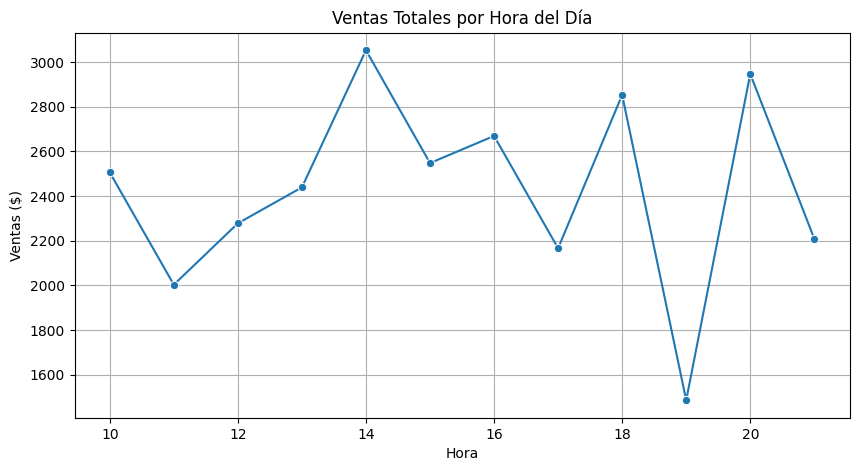

In [5]:

# Ventas por hora del día
ventas_hora = ventas.groupby('hora')['total'].sum().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=ventas_hora, x='hora', y='total', marker='o')
plt.title('Ventas Totales por Hora del Día')
plt.xlabel('Hora')
plt.ylabel('Ventas ($)')
plt.grid(True)
plt.show()


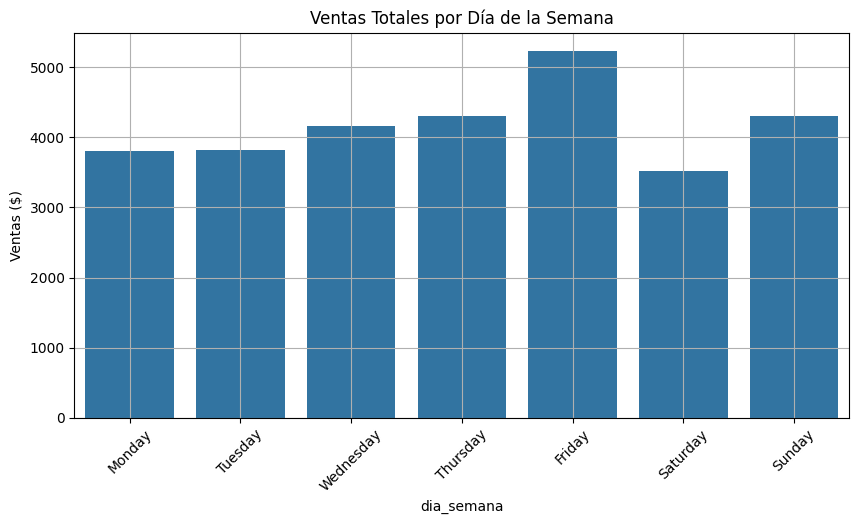

In [6]:

# Ventas por día de la semana
ventas_dia = ventas.groupby('dia_semana')['total'].sum().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=ventas_dia, x='dia_semana', y='total', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Ventas Totales por Día de la Semana')
plt.ylabel('Ventas ($)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


/tmp/ipython-input-7-3154099609.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_platillos = ventas_detalles.groupby(['franja_horaria', 'nombre_platillo'])['cantidad'].sum().reset_index()
/tmp/ipython-input-7-3154099609.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top3 = top_platillos.sort_values(['franja_horaria', 'cantidad'], ascending=[True, False]).groupby('franja_horaria').head(3)


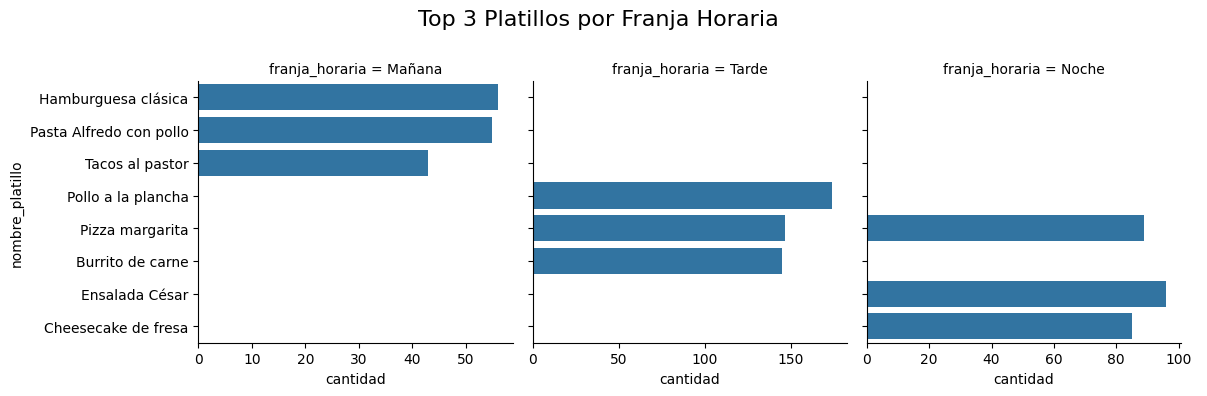

In [7]:

# Uniendo detalles con ventas y platillos
ventas_detalles = detalles.merge(ventas[['id_venta', 'hora', 'franja_horaria']], on='id_venta')
ventas_detalles = ventas_detalles.merge(platillos, on='id_platillo')

# Top 3 por franja
top_platillos = ventas_detalles.groupby(['franja_horaria', 'nombre_platillo'])['cantidad'].sum().reset_index()
top3 = top_platillos.sort_values(['franja_horaria', 'cantidad'], ascending=[True, False]).groupby('franja_horaria').head(3)

sns.catplot(data=top3, kind='bar', y='nombre_platillo', x='cantidad', col='franja_horaria', sharex=False, height=4)
plt.subplots_adjust(top=0.8)
plt.suptitle("Top 3 Platillos por Franja Horaria", fontsize=16)
plt.show()


bold text
## Clustering de Clientes (Segmentación)
Se usa clustering para identificar grupos de clientes según su comportamiento de compra. Esto permite entender qué tipos de clientes compran en diferentes franjas horarias.


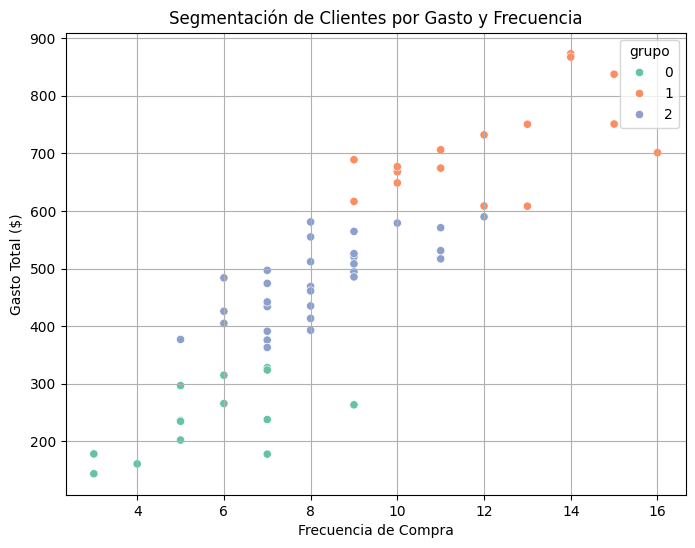

In [8]:

from sklearn.cluster import KMeans

# gasto total y frecuencia por cliente
clientes = ventas.groupby('id_cliente').agg({
    'total': 'sum',
    'id_venta': 'count'
}).rename(columns={'total': 'gasto_total', 'id_venta': 'frecuencia'})

# Clustering con KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
clientes['grupo'] = kmeans.fit_predict(clientes)

# Visualización del clustering
plt.figure(figsize=(8,6))
sns.scatterplot(data=clientes, x='frecuencia', y='gasto_total', hue='grupo', palette='Set2')
plt.title('Segmentación de Clientes por Gasto y Frecuencia')
plt.xlabel('Frecuencia de Compra')
plt.ylabel('Gasto Total ($)')
plt.grid(True)
plt.show()



## Análisis de Asociación (Market Basket)
Se buscan combinaciones frecuentes de platillos que se venden juntos para identificar oportunidades de combos o promociones por franja horaria.


In [9]:

from mlxtend.frequent_patterns import apriori, association_rules

# tabla tipo cesta
df = detalles.merge(platillos, on='id_platillo')
df = df.merge(ventas[['id_venta', 'franja_horaria']], on='id_venta')

basket = df.pivot_table(index='id_venta', columns='nombre_platillo', values='cantidad', aggfunc='sum')
basket = basket.fillna(0).applymap(lambda x: 1 if x > 0 else 0)

# Aplicar Apriori
frequent_items = apriori(basket, min_support=0.05, use_colnames=True)
rules = association_rules(frequent_items, metric='lift', min_threshold=1.1)

rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10)


/tmp/ipython-input-9-801471310.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.fillna(0).applymap(lambda x: 1 if x > 0 else 0)
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,support,confidence,lift
0,(Pasta Alfredo con pollo),(Burrito de carne),0.079151,0.315385,1.237646
1,(Burrito de carne),(Pasta Alfredo con pollo),0.079151,0.310606,1.237646
2,(Ensalada César),(Cheesecake de fresa),0.059846,0.242188,1.130208
3,(Cheesecake de fresa),(Ensalada César),0.059846,0.279279,1.130208
4,(Pollo a la plancha),(Lasagna boloñesa),0.077220,0.279720,1.149961
5,(Lasagna boloñesa),(Pollo a la plancha),0.077220,0.317460,1.149961


In [ ]:
from google.colab import drive
drive.mount('/content/drive')